In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

//anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
event_df = pd.read_csv("events.csv.zip")
event_df = event_df.sort_values('timestamp')
score_map = {'view':1, 'addtocart':2, 'transaction':3}
event_df['score'] = event_df.event.map(score_map)
event_df.head()

,timestamp,visitorid,event,itemid,transactionid,score
1462974,1430622004384,693516,addtocart,297662,NaN,2
1464806,1430622011289,829044,view,60987,NaN,1
1463000,1430622013048,652699,view,252860,NaN,1
1465287,1430622024154,1125936,view,33661,NaN,1
1462955,1430622026228,693516,view,297662,NaN,1


In [3]:
event_df.shape

(2756101, 6)

In [4]:
def get_median_time_lapse(ts_series):
    if len(ts_series) < 5:
        return None
    res = ts_series - ts_series.shift()
    res = res[1:]
    return np.median(res)
# event_df[:300000].groupby('visitorid').timestamp.apply(get_median_time_lapse).hist(bins=100)

# How frequent are purchases?

In [5]:
from datetime import datetime

timestamp = 1545730073 - 1e6
dt_object = datetime.fromtimestamp(timestamp)

print("dt_object =", dt_object)
print("type(dt_object) =", type(dt_object))

dt_object = 2018-12-13 20:41:13
type(dt_object) = <class 'datetime.datetime'>


In [6]:
pd.to_datetime(event_df.timestamp.min(), unit='ms'), pd.to_datetime(event_df.timestamp.max(), unit='ms')

(Timestamp('2015-05-03 03:00:04.384000'),
 Timestamp('2015-09-18 02:59:47.788000'))

# Remove customers only views and views too often (20+ views)

In [7]:
for v in event_df.event.unique():
    event_df[v] = event_df.event == v
actions_by_user = event_df.groupby("visitorid")[['view', 'addtocart','transaction']].agg([sum, 'mean'])
actions_by_user.head()

view      addtocart      transaction     
           sum mean       sum mean         sum mean
visitorid                                          
0          3.0  1.0       0.0  0.0         0.0  0.0
1          1.0  1.0       0.0  0.0         0.0  0.0
2          8.0  1.0       0.0  0.0         0.0  0.0
3          1.0  1.0       0.0  0.0         0.0  0.0
4          1.0  1.0       0.0  0.0         0.0  0.0

In [8]:
median_view_buy_ratio = actions_by_user[actions_by_user['transaction']['sum']>0]
median_view_buy_ratio = median_view_buy_ratio['view']['sum'] / median_view_buy_ratio['transaction']['sum']
print(np.percentile(median_view_buy_ratio,[50, 75, 90]))
del median_view_buy_ratio

[ 3.          7.         13.56410256]


In [9]:
views_by_user = actions_by_user['view']
(views_by_user[views_by_user['mean']==1]['sum']>13).mean()

0.00545694319124142

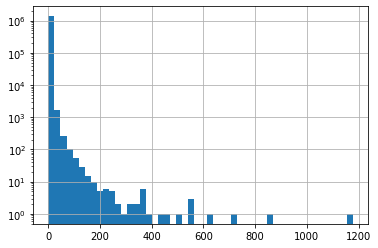

In [10]:
plt.yscale('log')
views_by_user[views_by_user['mean']==1]['sum'].hist(bins=50)

In [11]:
print('Before: ', event_df.shape)
event_df = event_df[~event_df.visitorid.isin(views_by_user[(views_by_user['sum']>13)&(views_by_user['mean']==1)].index.values)]
print('After: ', event_df.shape)

Before:  (2756101, 9)
After:  (2558598, 9)


In [12]:
from gc import collect
collect()

4948

# Remove customers never buys but view/add-to-cart too often

In [13]:
actions_by_user = event_df.groupby("visitorid")[['view', 'addtocart','transaction']].agg([sum, 'mean'])
actions_by_user['non_transaction'] = actions_by_user['view']['sum'] + actions_by_user['addtocart']['sum']

In [14]:
nontrans_trans_ratio = actions_by_user[actions_by_user['transaction']['sum']>0]
nontrans_trans_ratio = nontrans_trans_ratio['non_transaction'] / nontrans_trans_ratio['transaction']['sum']
print(np.percentile(nontrans_trans_ratio,[50, 75, 90]))
del nontrans_trans_ratio

[ 4.  8. 15.]


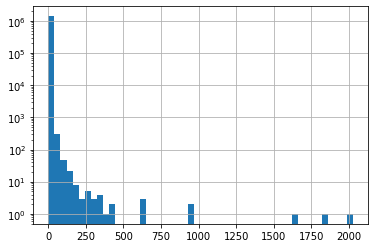

In [15]:
plt.yscale('log')
actions_by_user[actions_by_user['transaction']['sum']==0].non_transaction.hist(bins=50)

In [16]:
(actions_by_user[actions_by_user['transaction']['sum']==0].non_transaction>20).mean()

0.0010018784320278422

In [17]:
print('Before: ', event_df.shape)
event_df = event_df[~event_df.visitorid.isin(actions_by_user[(actions_by_user['transaction']['sum']==0)&(actions_by_user['non_transaction']>39)].index.values)]
print('After: ', event_df.shape)


Before:  (2558598, 9)
After:  (2515925, 9)


In [18]:
collect()

3278

# Remove too infrequent users/items

In [19]:
event_df.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2493468
score                  0
addtocart              0
view                   0
transaction            0
dtype: int64

In [20]:
visitor_score = event_df.groupby('visitorid').score.count()
(visitor_score<5).mean()

0.9473497697999217

In [21]:
item_score = event_df.groupby('itemid').score.count()
(item_score<5).mean()

0.6187950030934485

In [22]:
b = 1e10
a = event_df.shape[0]
thres_v = 4
thres_i = 4
while a < b:
    b = a
    visitor_score = event_df.groupby('visitorid').score.count()
    item_score = event_df.groupby('itemid').score.count()
    print('Before: ', event_df.shape)
    event_df = event_df[event_df.visitorid.isin(visitor_score.index.values[visitor_score>thres_v])&
                        event_df.itemid.isin(item_score.index.values[item_score>thres_i])
                       ]
    print('After: ', event_df.shape)
    a = event_df.shape[0]

Before:  (2515925, 9)
After:  (671145, 9)
Before:  (671145, 9)
After:  (596591, 9)
Before:  (596591, 9)
After:  (563066, 9)
Before:  (563066, 9)
After:  (555000, 9)
Before:  (555000, 9)
After:  (550261, 9)
Before:  (550261, 9)
After:  (549008, 9)
Before:  (549008, 9)
After:  (548192, 9)
Before:  (548192, 9)
After:  (547913, 9)
Before:  (547913, 9)
After:  (547747, 9)
Before:  (547747, 9)
After:  (547678, 9)
Before:  (547678, 9)
After:  (547609, 9)
Before:  (547609, 9)
After:  (547572, 9)
Before:  (547572, 9)
After:  (547532, 9)
Before:  (547532, 9)
After:  (547526, 9)
Before:  (547526, 9)
After:  (547524, 9)
Before:  (547524, 9)
After:  (547524, 9)


In [23]:
visitor_score.min(), item_score.min()

(5, 5)

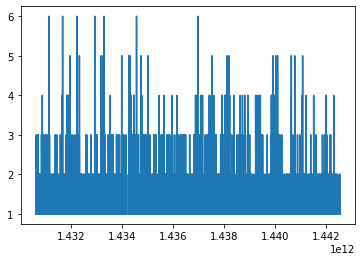

In [24]:
event_df.timestamp.value_counts().sort_index().plot()

In [25]:
def get_largest_score(df):
    df = df.sort_values(['score','timestamp'], ascending=False)
    res = pd.Series({'score': df.iloc[0].score,
                     'timestamp': df.iloc[0].timestamp
                    })
    return res

def dedup(df):
    print('Before:', df.shape)
    df = df.groupby(['visitorid', 'itemid']).apply(get_largest_score).reset_index()
    df['event'] = df.score.map({v:k for k, v in score_map.items()})
    print('After:', df.shape)
    return df

In [26]:
dedup(event_df[event_df.visitorid==979664])

Before: (9, 9)
After: (7, 5)


,visitorid,itemid,score,timestamp,event
0,979664,54805,1,1430622459202,view
1,979664,91998,1,1430622154356,view
2,979664,338222,2,1430622085008,addtocart
3,979664,346597,1,1433052824778,view
4,979664,355594,1,1430622591111,view
5,979664,430965,1,1430622231863,view
6,979664,454393,1,1430622312158,view


In [27]:
collect()

20

# Final 

In [28]:
# thres = event_df.timestamp.min()+2.6e9
# train = event_df[event_df.timestamp<thres]
# train = dedup(train)
# test = event_df[(event_df.timestamp>=thres) & (event_df.timestamp<thres+4e8)]
# test = dedup(test)


thres = int(0.7*len(event_df))
train = event_df[:thres]
train = dedup(train)
test = event_df[thres:]
test = dedup(test)
train['dataset'] = 'train'
test['dataset'] = 'test'
combine_df = pd.concat((train, test))

Before: (383266, 9)
After: (201287, 5)
Before: (164258, 9)
After: (86554, 5)


In [29]:
collect()
display(combine_df[['visitorid', 'itemid']].nunique())

visitorid    55020
itemid       28810
dtype: int64

## Without filter

In [30]:
from helpers import df_to_matrix


train, test, uid_to_idx, idx_to_uid,\
mid_to_idx, idx_to_mid = df_to_matrix(combine_df, 'visitorid', 'itemid')

In [31]:
train, test

(<55020x28810 sparse matrix of type '<class 'numpy.float64'>'
 	with 201287 stored elements in Compressed Sparse Row format>,
 <55020x28810 sparse matrix of type '<class 'numpy.float64'>'
 	with 86554 stored elements in Compressed Sparse Row format>)

In [60]:
from helpers import patk_learning_curve, plot_patk
model = LightFM(loss='warp', random_state=2016, no_components=8)


iterarray = range(5, 55, 2)

model, train_precisions, test_precisions, train_recalls, test_recalls = patk_learning_curve(
    model, train, test, iterarray, num_threads=8
)

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

# 19 6.2 12.6

+------------+------------+------------+------------+------------+
|   Epoch    | train p@3  |  test p@3  | train r@100 | test r@100 |
+============+============+============+============+============+
|     5      |  0.00405   |  0.03469   |  0.17352   |  0.05070   |
+------------+------------+------------+------------+------------+
|     7      |  0.00501   |  0.04500   |  0.26769   |  0.05219   |
+------------+------------+------------+------------+------------+
|     9      |  0.00430   |  0.04807   |  0.33662   |  0.05463   |
+------------+------------+------------+------------+------------+
|     11     |  0.00555   |  0.05056   |  0.38935   |  0.05740   |
+------------+------------+------------+------------+------------+
|     13     |  0.00615   |  0.05292   |  0.43102   |  0.05849   |
+------------+------------+------------+------------+------------+
|     15     |  0.00635   |  0.05484   |  0.46501   |  0.06007   |
+------------+------------+------------+------------+--------

ValueError: too many values to unpack (expected 3)

In [ ]:
from helpers import patk_learning_curve, plot_patk
import seaborn as sns
import matplotlib.pyplot as plt
# Plot train on left
ax = plt.subplot(1, 2, 1)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, train_patk,
         'Train', k=5)

# Plot test on right
ax = plt.subplot(1, 2, 2)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, test_patk,
         'Test', k=5)

plt.tight_layout();


## Filter only in test

In [33]:
combine_df.shape

(287841, 6)

In [34]:
from helpers import df_to_matrix
train1, test1, uid_to_idx1, idx_to_uid1,\
mid_to_idx1, idx_to_mid1 = df_to_matrix(combine_df, 'visitorid', 'itemid', filter_in_test=True)
train1, test1

(<19776x23962 sparse matrix of type '<class 'numpy.float64'>'
 	with 29799 stored elements in Compressed Sparse Row format>,
 <19776x23962 sparse matrix of type '<class 'numpy.float64'>'
 	with 86554 stored elements in Compressed Sparse Row format>)

In [35]:
from helpers import patk_learning_curve, plot_patk
model = LightFM(loss='warp', random_state=2016, no_components=8, max_sampled=15)


iterarray = range(5, 55, 2)

model, train_precisions, test_precisions, train_recalls, test_recalls = patk_learning_curve(
    model, train1, test1, iterarray, num_threads=8
)

train_auc = auc_score(model, train1).mean()
test_auc = auc_score(model, test1).mean()

print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

+------------+------------+------------+------------+------------+
|   Epoch    | train p@3  |  test p@3  | train r@100 | test r@100 |
+============+============+============+============+============+
|     5      |  0.00543   |  0.02608   |  0.16212   |  0.05023   |
+------------+------------+------------+------------+------------+
|     7      |  0.00539   |  0.03642   |  0.25341   |  0.05510   |
+------------+------------+------------+------------+------------+
|     9      |  0.00440   |  0.04213   |  0.33790   |  0.05905   |
+------------+------------+------------+------------+------------+
|     11     |  0.00445   |  0.04346   |  0.44107   |  0.06361   |
+------------+------------+------------+------------+------------+
|     13     |  0.00474   |  0.04536   |  0.55563   |  0.06991   |
+------------+------------+------------+------------+------------+
|     15     |  0.00490   |  0.04784   |  0.66682   |  0.07698   |
+------------+------------+------------+------------+--------

In [36]:
import pickle

with open('full_model_only_in_test.pickle', 'wb') as fle:
    pickle.dump(model, fle, protocol=pickle.HIGHEST_PROTOCOL)

## Filter in both

In [64]:
train2, test2, uid_to_idx2, idx_to_uid2,\
mid_to_idx2, idx_to_mid2 = df_to_matrix(combine_df, 'visitorid', 'itemid', filter_in_test=True,
                                        filter_in_train= True
                                       )
train2, test2

/Users/macintoshhd/recommend_sys/helpers.py:230: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  I = df[row_name][df.dataset==ds].apply(map_ids, args=[rid_to_idx]).as_matrix()
/Users/macintoshhd/recommend_sys/helpers.py:231: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  J = df[col_name][df.dataset==ds].apply(map_ids, args=[cid_to_idx]).as_matrix()


(<5254x18566 sparse matrix of type '<class 'numpy.float64'>'
 	with 29799 stored elements in Compressed Sparse Row format>,
 <5254x18566 sparse matrix of type '<class 'numpy.float64'>'
 	with 20616 stored elements in Compressed Sparse Row format>)

In [65]:
from helpers import patk_learning_curve, plot_patk
model = LightFM(loss='warp', random_state=2016, no_components=8, max_sampled=15)


iterarray = range(5, 55, 2)

model, train_precisions, test_precisions, train_recalls, test_recalls = patk_learning_curve(
    model, train2, test2, iterarray, num_threads=8
)

train_auc = auc_score(model, train2).mean()
test_auc = auc_score(model, test2).mean()

print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))
# AUC: train 0.94, test 0.63. 15 rounds 4 comps

+------------+------------+------------+------------+------------+
|   Epoch    | train p@3  |  test p@3  | train r@100 | test r@100 |
+============+============+============+============+============+
|     5      |  0.00615   |  0.02227   |  0.15592   |  0.06729   |
+------------+------------+------------+------------+------------+
|     7      |  0.00882   |  0.03692   |  0.23897   |  0.08430   |
+------------+------------+------------+------------+------------+
|     9      |  0.01015   |  0.04600   |  0.32354   |  0.10166   |
+------------+------------+------------+------------+------------+
|     11     |  0.01155   |  0.05183   |  0.42420   |  0.12301   |
+------------+------------+------------+------------+------------+
|     13     |  0.01320   |  0.05494   |  0.53537   |  0.14633   |
+------------+------------+------------+------------+------------+
|     15     |  0.01377   |  0.05792   |  0.66192   |  0.18151   |
+------------+------------+------------+------------+--------

In [66]:
with open('full_model_only_in_both.pickle', 'wb') as fle:
    pickle.dump(model, fle, protocol=pickle.HIGHEST_PROTOCOL)

# Add item features

In [44]:
item_df = []
for f in ['item_properties_part1.csv.zip', 'item_properties_part2.csv.zip']:
    df = pd.read_csv(f)
    df = df[df.itemid.isin(mid_to_idx1.keys())]
    item_df.append(df)
item_df = pd.concat(item_df)
print(item_df.shape)
item_df.head()

(1638642, 4)


,timestamp,itemid,property,value
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
18,1437274800000,49337,0,n36.000 1186610 119932 717520 903287 98606 632...
20,1439694000000,48696,566,n480.000 639502 189174
22,1434250800000,269797,159,519769
27,1435460400000,334428,216,637368 190776


In [129]:
train_thres = combine_df[combine_df.dataset=='test'].timestamp.min()
item_df = item_df.sort_values(['itemid', 'property', 'timestamp'])
item_train_df = item_df.groupby(['itemid', 'property']).first().reset_index()
item_test_df = pd.concat((item_df[item_df.timestamp < train_thres].groupby(['itemid', 'property']).last().reset_index(),
                          item_train_df[item_train_df.timestamp >= train_thres]
                         ))
item_train_df.shape, item_test_df.shape, len(mid_to_idx1.keys())

((679026, 4), (679026, 4), 23962)

In [130]:
def fill_item_features_w_fake_properties(item_df):
    fake_itemid = []
    fake_timestamp = []
    fake_property = []
    fake_value = []
    all_items_with_property = set(item_df.itemid)
    for itx in mid_to_idx1.keys():
        if itx not in all_items_with_property:
            fake_itemid.insert(0, itx)
            fake_timestamp.insert(0, 0)
            fake_property.insert(0, 888)
            fake_value.insert(0, 0)

    fake_property_dict = {'itemid':fake_itemid, 'timestamp':fake_timestamp, 'property':fake_property,
                         'value':fake_value}

    fake_df = pd.DataFrame(fake_property_dict, columns=item_df.columns.values)
    filtered_items = pd.concat([item_df, fake_df])
    filtered_items['itemid'] = filtered_items['itemid'].apply(lambda x: mid_to_idx1[x])
    filtered_items.sort_values(by='itemid', inplace=True)
    item_to_property_matrix = filtered_items.pivot(index='itemid', columns='property', values='value')
    return item_to_property_matrix
item_train_df = fill_item_features_w_fake_properties(item_train_df)
item_test_df = fill_item_features_w_fake_properties(item_test_df)
item_train_df.shape, item_test_df.shape, len(mid_to_idx1.keys())

((23962, 976), (23962, 976), 23962)

In [131]:
def check_numerical(x):
    if not pd.isnull(x):
        t = x.split()
        if (len(t)==1) & (t[0].startswith('n')):
            return True
        else:
            return False
    return True
cols_by_num_values = item_train_df.astype(str).applymap(check_numerical).mean()
numerical_propeties = set(cols_by_num_values[cols_by_num_values==1].index.values)

In [132]:
dense_properties = item_train_df.isnull().mean()
dense_properties = set(dense_properties[dense_properties<.5].index.values)

categorical_properties = item_train_df.nunique()
categorical_properties = set(categorical_properties[(categorical_properties<200)&(categorical_properties>1)].index.values)

useful_item_properties = dense_properties&(categorical_properties|numerical_propeties)
useful_item_properties = ['227', '6', '678', '698', '839', 'available', '790', 'categoryid']
useful_item_properties

['227', '6', '678', '698', '839', 'available', '790', 'categoryid']

In [133]:
item_train_df['790'].str[1:].astype(float)==0

itemid
0        False
1        False
2        False
3        False
4        False
         ...  
23957    False
23958    False
23959    False
23960    False
23961    False
Name: 790, Length: 23962, dtype: bool

In [134]:
t.shape

(23962, 8)

In [135]:
item_train_df.any(axis=1)

itemid
0         True
1         True
2         True
3         True
4         True
         ...  
23957     True
23958     True
23959     True
23960     True
23961    False
Length: 23962, dtype: bool

In [136]:
def fix_categoryid(x):
    if pd.isna(x):
        return
    return str(int(x))

category_tree = pd.read_csv('category_tree.csv')
category_tree = category_tree.applymap(fix_categoryid)
category_tree.set_index('categoryid', inplace=True)

In [137]:
collect()

893

In [140]:
# def search_tree(cate):
#     if pd.isna(cate):
#         return
#     if cate=='rare':
#         return
#     return category_tree.parentid.loc[cate]
# cat_cols = ['227', '6', '678', '698', '839', 'available']
# from sklearn.preprocessing import MinMaxScaler
# from feature_engine import categorical_encoders as ce
# t = item_train_df['790'].str[1:].astype(float)+1
# scaler = MinMaxScaler()
# scaler.fit(t.fillna(1).apply(np.log).values.reshape(-1, 1))

# t = item_train_df[useful_item_properties].fillna('rare')
# encoder = ce.RareLabelCategoricalEncoder(tol=0.03, n_categories=2,
#                                          variables= cat_cols,
#                                          replace_with='rare', return_object=True)
# encoder.fit(t)

uniq_cat = set(category_tree.index.values)|set(category_tree.parentid.dropna())

def prep_item_property(item_to_property_matrix):
    item_to_property_matrix = item_to_property_matrix[useful_item_properties]
    item_to_property_matrix['categoryid'] = item_to_property_matrix['categoryid'].apply(fix_categoryid)
    item_to_property_matrix['790'] = (item_to_property_matrix['790'].str[1:].astype(float) + 1).fillna(1).apply(np.log)
    item_to_property_matrix['790'] = scaler.transform(item_to_property_matrix['790'].values.reshape(-1, 1)).reshape(-1)
    
    item_to_property_matrix = encoder.transform(item_to_property_matrix.fillna('rare'))
    item_to_property_matrix_one_hot_sparse = pd.get_dummies(item_to_property_matrix, 
                                                        columns = ['categoryid']+cat_cols,
                                                            prefix = ['category']+ cat_cols
                                                       )
    item_to_property_matrix = item_to_property_matrix.rename(columns={'categoryid':'categoryid0'})
    for i in range(1,5):
        item_to_property_matrix['categoryid'+str(i)] = item_to_property_matrix['categoryid'+str(i-1)].apply(search_tree)
    for cat in uniq_cat:
        item_to_property_matrix_one_hot_sparse['category_' + cat] = (item_to_property_matrix[['categoryid'+str(i) for i in range(0, 5)]]==cat).any(axis=1)   
    return item_to_property_matrix_one_hot_sparse
prep_item_property(item_train_df.head(5))


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,790,category_1051,category_1219,227_977762,227_rare,6_977762,6_rare,678_rare,698_977762,698_rare,...,category_261,category_187,category_1255,category_1025,category_1271,category_587,category_457,category_35,category_1529,category_1356
itemid,,,,,,,,,,,,,,,,,,,,,
0,0.606925,True,False,1,0,1,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
1,0.610063,True,False,1,0,1,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
2,0.594922,True,False,1,0,1,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
3,0.600302,True,False,1,0,1,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
4,0.530827,False,True,0,1,0,1,1,0,1,...,False,False,False,False,False,False,False,False,False,False


In [141]:
item_train_df = prep_item_property(item_train_df)
item_test_df = prep_item_property(item_test_df)
item_test_df.head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,790,category_0,category_1,category_1001,category_1002,category_1003,category_1006,category_1007,category_1008,category_1011,...,category_1590,category_1551,category_1644,category_923,category_275,category_1311,category_187,category_1025,category_1271,category_587
itemid,,,,,,,,,,,,,,,,,,,,,
0,0.605523,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.610837,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.594922,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.600302,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.518839,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [142]:
item_train_df.sum()

790              11975.454882
category_0          16.000000
category_1          62.000000
category_1001       15.000000
category_1002       41.000000
                     ...     
category_1311        0.000000
category_187        78.000000
category_1025        0.000000
category_1271        0.000000
category_587       173.000000
Length: 1685, dtype: float64

In [145]:
for c in item_train_df.columns:
    if (item_train_df[c].sum() == 0)&(item_test_df[c].sum() == 0):
        del item_train_df[c], item_test_df[c]
    elif (item_train_df[c].mean() == 1)&(item_test_df[c].mean() == 1):
        del item_train_df[c], item_test_df[c]
item_train_df.shape, item_test_df.shape

((23962, 1077), (23962, 1077))

In [146]:
from lightfm import LightFM
import scipy.sparse as sp
from scipy.sparse import vstack


In [150]:
item_train_df = item_train_df.fillna(0).astype(np.float16)
item_test_df = item_test_df.fillna(0).astype(np.float16)

In [148]:
from scipy.sparse import csr_matrix
import scipy as sp

def stack_one_hot_enc(mx):
    eye = sp.eye(mx.shape[0], mx.shape[0])#.tocsr()
    item_features_concat = sp.hstack((eye, mx))
    item_features_concat = csr_matrix(item_features_concat)
    return item_features_concat
item_train_mx = stack_one_hot_enc(item_train_df)
item_test_mx = stack_one_hot_enc(item_test_df)
item_train_mx.shape,item_test_mx.shape

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.eye is deprecated and will be removed in SciPy 2.0.0, use numpy.eye instead
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.hstack is deprecated and will be removed in SciPy 2.0.0, use numpy.hstack instead
  import sys


((23962, 25039), (23962, 25039))

In [152]:
from helpers import patk_learning_curve
model = LightFM(loss='warp', random_state=2016, no_components=8, max_sampled=15)


iterarray = range(5, 55, 2)

model, train_precisions, test_precisions, train_recalls, test_recalls = patk_learning_curve(
    model, train1, test1, iterarray, num_threads=8, 
    item_features_train=csr_matrix(item_train_df), item_features_test=csr_matrix(item_test_df)
)

train_auc = auc_score(model, train1).mean()
test_auc = auc_score(model, test1).mean()

print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

+------------+------------+------------+------------+------------+
|   Epoch    | train p@3  |  test p@3  | train r@100 | test r@100 |
+============+============+============+============+============+
|     5      |  0.00019   |  0.00945   |  0.22816   |  0.00568   |
+------------+------------+------------+------------+------------+
|     7      |  0.00008   |  0.01313   |  0.31122   |  0.00613   |
+------------+------------+------------+------------+------------+
|     9      |  0.00007   |  0.01637   |  0.36719   |  0.00604   |
+------------+------------+------------+------------+------------+
|     11     |  0.00008   |  0.01846   |  0.40859   |  0.00583   |
+------------+------------+------------+------------+------------+


KeyboardInterrupt: 

# Time-based

In [37]:
time_test_thres = '2015-07-26 03:00:00'
event_df['timestamp'] = pd.to_datetime(event_df['timestamp'], unit='ms')
# item_df['timestamp'] = pd.to_datetime(item_df['timestamp'], unit='ms')
event_df.head()

NameError: name 'item_df' is not defined

In [38]:
event_df['timestamp'].max()

Timestamp('2015-09-18 02:58:58.914000')

In [ ]:
from pandas import Timestamp
import datetime
base = Timestamp('2015-08-02 03:00:00')
date_list = [base + datetime.timedelta(days=x) for x in range(47)]
'2015-09-18 02:59:47.788000'

# for thres in [Timestamp('2015-08-02 03:00:00'),
#               Timestamp('2015-08-09 03:00:00'),
#               Timestamp('2015-08-16 03:00:00'),
#               Timestamp('2015-08-23 03:00:00'),
#               Timestamp('2015-08-30 03:00:00'),
#               Timestamp('2015-09-06 03:00:00'),
#               Timestamp('2015-09-13 03:00:00')]:
log_records = []
for thres in date_list:
    train = event_df[(event_df.timestamp<= thres)&(event_df.timestamp>thres - pd.to_timedelta('30 days'))]
    test = event_df[(event_df.timestamp > thres)&(event_df.timestamp <= thres + pd.to_timedelta('1 days'))]
    train = dedup(train)
    test = dedup(test)
    train['dataset'] = 'train'
    test['dataset'] = 'test'
    combine_df = pd.concat((train, test))
    
    train1, test1, uid_to_idx1, idx_to_uid1, \
        mid_to_idx1, idx_to_mid1 = df_to_matrix(combine_df, 'visitorid', 'itemid', filter_in_test=True)
    model = LightFM(loss='warp', random_state=2016, no_components=7, max_sampled=15)


    iterarray = range(5, 55, 2)

    model, train_precisions, test_precisions, train_recalls, test_recalls = patk_learning_curve(
        model, train1, test1, iterarray, num_threads=8
    )
    
    train_auc = auc_score(model, train1).mean()
    test_auc = auc_score(model, test1).mean()
    log_records.append([len(uid_to_idx1), len(test), train_precisions, test_precisions, train_recalls, test_recalls])
    print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))
    print()

Before: (132321, 9)
After: (71546, 5)
Before: (2763, 9)
After: (1699, 5)
+------------+------------+------------+------------+------------+
|   Epoch    | train p@3  |  test p@3  | train r@100 | test r@100 |
+============+============+============+============+============+
|     5      |  0.00660   |  0.03681   |  0.20880   |  0.07692   |
+------------+------------+------------+------------+------------+
|     7      |  0.01116   |  0.06135   |  0.28316   |  0.09473   |
+------------+------------+------------+------------+------------+
|     9      |  0.01218   |  0.06953   |  0.39642   |  0.12329   |
+------------+------------+------------+------------+------------+
|     11     |  0.01776   |  0.09816   |  0.53137   |  0.15558   |
+------------+------------+------------+------------+------------+
|     13     |  0.02232   |  0.13292   |  0.75160   |  0.22367   |
+------------+------------+------------+------------+------------+
|     15     |  0.02943   |  0.16053   |  0.90779   |  

|     15     |  0.01124   |  0.11469   |  0.95037   |  0.29537   |
+------------+------------+------------+------------+------------+
|     17     |  0.01616   |  0.13146   |  0.97661   |  0.30420   |
+------------+------------+------------+------------+------------+
|     19     |  0.01756   |  0.14286   |  0.98629   |  0.30941   |
+------------+------------+------------+------------+------------+
|     21     |  0.02213   |  0.17103   |  0.98637   |  0.31004   |
+------------+------------+------------+------------+------------+
|     23     |  0.02459   |  0.17975   |  0.98861   |  0.31102   |
+------------+------------+------------+------------+------------+
|     25     |  0.03056   |  0.19517   |  0.98888   |  0.31061   |
+------------+------------+------------+------------+------------+
|     27     |  0.03091   |  0.20121   |  0.98951   |  0.30899   |
+------------+------------+------------+------------+------------+
|     29     |  0.03372   |  0.21529   |  0.98950   |  0.30847

|     29     |  0.03513   |  0.22799   |  0.98587   |  0.29661   |
+------------+------------+------------+------------+------------+
|     31     |  0.03591   |  0.24170   |  0.98674   |  0.29701   |
+------------+------------+------------+------------+------------+
|     33     |  0.03591   |  0.25253   |  0.98674   |  0.29541   |
+------------+------------+------------+------------+------------+
|     35     |  0.03981   |  0.25902   |  0.98682   |  0.29455   |
+------------+------------+------------+------------+------------+
|     37     |  0.04489   |  0.28283   |  0.98686   |  0.29575   |
+------------+------------+------------+------------+------------+
|     39     |  0.04333   |  0.29509   |  0.98702   |  0.29420   |
+------------+------------+------------+------------+------------+
|     41     |  0.04528   |  0.30519   |  0.98713   |  0.29432   |
+------------+------------+------------+------------+------------+
|     43     |  0.04762   |  0.32035   |  0.98716   |  0.29375

|     43     |  0.10377   |  0.57306   |  0.99098   |  0.31889   |
+------------+------------+------------+------------+------------+
|     45     |  0.10629   |  0.58333   |  0.99098   |  0.31983   |
+------------+------------+------------+------------+------------+
|     47     |  0.10566   |  0.57648   |  0.99098   |  0.31992   |
+------------+------------+------------+------------+------------+
|     49     |  0.10692   |  0.58676   |  0.99098   |  0.31971   |
+------------+------------+------------+------------+------------+
|     51     |  0.11006   |  0.59361   |  0.99098   |  0.31886   |
+------------+------------+------------+------------+------------+
|     53     |  0.10818   |  0.60160   |  0.99098   |  0.31844   |
+------------+------------+------------+------------+------------+
AUC: train 1.00, test 0.52.

Before: (126330, 9)
After: (68419, 5)
Before: (2286, 9)
After: (1474, 5)
+------------+------------+------------+------------+------------+
|   Epoch    | train p@3  |

# RNN

In [51]:
combine_df = combine_df.sort_values(['visitorid', 'timestamp'])
combine_df.head()

,visitorid,itemid,score,timestamp,event,dataset
2,2,325215,1,1438969904567,view,test
1,2,259884,1,1438970212664,view,test
0,2,216305,1,1438970468920,view,test
3,2,342816,1,1438970905669,view,test
4,6,65273,2,1440914628202,addtocart,test


In [52]:
def sentenize_user(df):
    fun = df.event + ' ' + df.itemid.astype(str) + ' '
    df['tokenize_events'] = fun.cumsum()
    return df
rnn_df = combine_df.groupby('visitorid').apply(sentenize_user)

In [74]:
rnn_df.loc[9].tokenize_events.iloc[0]

'view 283115 view 38965 view 319680 view 442228 view 249114 '

In [94]:
rnn_df['num_tokens'] = rnn_df.tokenize_events.apply(lambda x: len(x.split()))
rnn_df[rnn_df['num_tokens'] == rnn_df['num_tokens'].max()]

,visitorid,itemid,score,timestamp,event,dataset,tokenize_events,num_tokens
90097,1150086,270534,1,1442458187612,view,test,view 231726 view 427777 transaction 398115 vie...,7286


In [97]:
rnn_df['tokenize_events'].loc[90097].iloc[-1]

'view 231726 view 427777 transaction 398115 view 458489 transaction 375955 transaction 357133 addtocart 368244 view 288099 view 417737 view 66046 view 190304 view 330894 view 340578 view 309821 view 415884 view 6888 view 212438 view 119737 view 36810 view 175485 view 340994 view 178274 view 46232 view 109352 transaction 119736 view 466109 view 408132 view 425920 view 302478 view 54427 view 107195 view 168944 view 81086 view 98807 view 305675 view 45226 view 411751 view 272596 view 207420 view 141009 view 334401 view 43267 view 89323 view 338395 view 76615 view 184331 view 143860 view 411886 view 428648 view 385857 view 321712 view 293719 transaction 310620 transaction 276704 view 458046 transaction 277638 view 297487 view 29082 view 16789 view 396706 transaction 440066 view 396336 view 50668 view 5848 view 280328 view 36370 transaction 263188 view 213593 addtocart 20740 view 150403 view 355605 view 304876 transaction 387863 view 385778 transaction 464196 view 273770 view 383084 view 18

In [ ]:
from fastai.text import *

class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.RNN(nh,nh, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [48]:
!pip install Keras

     |████████████████████████████████| 378kB 1.8MB/s eta 0:00:01


In [112]:
from __future__ import print_function
import numpy as np

# method for generating text
def generate_text(model, length, vocab_size, ix_to_char):
    # starting wbith random character
	ix = [np.random.randint(vocab_size)]
	y_char = [ix_to_char[ix[-1]]]
	X = np.zeros((1, length, vocab_size))
	for i in range(length):
		# appending the last predicted character to sequence
		X[0, i, :][ix[-1]] = 1
		print(ix_to_char[ix[-1]], end=" ")
		ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
		y_char.append(ix_to_char[ix[-1]])
	return (' ').join(y_char)

# method for preparing the training data
def load_data(data, seq_length):
    chars = list(set(data))
    VOCAB_SIZE = len(chars)
# 	chars = combine_df.itemid.unique().tolist() + combine_df.event_id.unique().tolist()
# 	VOCAB_SIZE = len(chars)

    print('Vocabulary size: {} words'.format(VOCAB_SIZE))

    ix_to_char = {ix:char for ix, char in enumerate(chars)}
    char_to_ix = {char:ix for ix, char in enumerate(chars)}
    
    r = int(len(data)/seq_length)
    X = np.zeros((r, seq_length, VOCAB_SIZE))
    y = np.zeros((r, seq_length, VOCAB_SIZE))
    for i in range(0, r):
        X_sequence = data[i*seq_length:(i+1)*seq_length]
        X_sequence_ix = [char_to_ix[value] for value in X_sequence]
        input_sequence = np.zeros((seq_length, VOCAB_SIZE))
        for j in range(seq_length):
            input_sequence[j][X_sequence_ix[j]] = 1.
            X[i] = input_sequence

        y_sequence = data[i*seq_length+1:(i+1)*seq_length+1]
        y_sequence_ix = [char_to_ix[value] for value in y_sequence]
        target_sequence = np.zeros((seq_length, VOCAB_SIZE))
        for j in range(seq_length):
            try:
                target_sequence[j][y_sequence_ix[j]] = 1.
            except:
                import pdb; pdb.set_trace()
            y[i] = target_sequence
    return X, y, VOCAB_SIZE, ix_to_char

In [113]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, SimpleRNN
from keras.layers.wrappers import TimeDistributed

In [132]:
words = "view 357133 addtocart 368244"
words = words.split()*1000
words = words[:1001]

In [133]:
HIDDEN_DIM = 4
LAYER_NUM = 3
generate_length = 2
BATCH_SIZE = 32

X, y, VOCAB_SIZE, ix_to_char = load_data(words,8)

model = Sequential()
model.add(LSTM(HIDDEN_DIM, input_shape=(None, VOCAB_SIZE), return_sequences=True))
for i in range(LAYER_NUM - 1):
    model.add(LSTM(HIDDEN_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(VOCAB_SIZE)))
model.add(Activation('softmax'))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
generate_text(model, generate_length, VOCAB_SIZE, ix_to_char)

Vocabulary size: 4 words
368244 357133 

'368244 357133 357133'

In [134]:
WEIGHTS = ''
nb_epoch = 0

# Training if there is no trained weights specified
# while nb_epoch < 100:
print('\n\nEpoch: {}\n'.format(nb_epoch))
model.fit(X, y, batch_size=BATCH_SIZE, verbose=1, nb_epoch=300)
# nb_epoch += 1
generate_text(model, generate_length, VOCAB_SIZE, ix_to_char)
# if nb_epoch % 10 == 0:
#     model.save_weights('checkpoint_layer_{}_hidden_{}_epoch_{}.hdf5'.format(LAYER_NUM, HIDDEN_DIM, nb_epoch))




Epoch: 0



//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/300
125/125 [==============================] - 2s 12ms/step - loss: 1.3865
Epoch 2/300
125/125 [==============================] - 0s 622us/step - loss: 1.3841
Epoch 3/300
125/125 [==============================] - 0s 502us/step - loss: 1.3819
Epoch 4/300
125/125 [==============================] - 0s 433us/step - loss: 1.3796
Epoch 5/300
125/125 [==============================] - 0s 453us/step - loss: 1.3771
Epoch 6/300
125/125 [==============================] - 0s 520us/step - loss: 1.3742
Epoch 7/300
125/125 [==============================] - 0s 420us/step - loss: 1.3712
Epoch 8/300
125/125 [==============================] - 0s 408us/step - loss: 1.3680
Epoch 9/300
125/125 [==============================] - 0s 375us/step - loss: 1.3646
Epoch 10/300
125/125 [==============================] - 0s 390us/step - loss: 1.3613
Epoch 11/300
125/125 [==============================] - 0s 388us/step - loss: 1.3580
Epoch 12/300
125/125 [==============================] - ETA: 0s - loss: 1.3

125/125 [==============================] - 0s 361us/step - loss: 1.0948
Epoch 193/300
125/125 [==============================] - 0s 336us/step - loss: 1.0939
Epoch 194/300
125/125 [==============================] - 0s 321us/step - loss: 1.0930
Epoch 195/300
125/125 [==============================] - 0s 344us/step - loss: 1.0921
Epoch 196/300
125/125 [==============================] - 0s 493us/step - loss: 1.0913
Epoch 197/300
125/125 [==============================] - 0s 499us/step - loss: 1.0904
Epoch 198/300
125/125 [==============================] - 0s 333us/step - loss: 1.0895
Epoch 199/300
125/125 [==============================] - 0s 323us/step - loss: 1.0887
Epoch 200/300
125/125 [==============================] - 0s 365us/step - loss: 1.0878
Epoch 201/300
125/125 [==============================] - 0s 326us/step - loss: 1.0870
Epoch 202/300
125/125 [==============================] - 0s 342us/step - loss: 1.0861
Epoch 203/300
125/125 [==============================] - 0s 396us/st

'view 357133 357133'

In [139]:
generate_text(model, 6, VOCAB_SIZE, ix_to_char)

addtocart 357133 view view view view 

'addtocart 357133 view view view view view'